In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('HABILITANDO GPU - DONE')

Found GPU at: /device:GPU:0
HABILITANDO GPU - DONE


In [2]:
!nvidia-smi

Sun Oct  4 17:34:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    32W /  70W |    227MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

print('DONE')

Mounted at /content/drive
DONE


In [5]:
import pandas
import matplotlib.pyplot as plt
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

print('DONE')

DONE


In [6]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
print('DONE')

DONE


Epoch 1/50
147385/147385 - 302s - loss: 0.1674
Epoch 2/50
147385/147385 - 294s - loss: 0.1665
Epoch 3/50
147385/147385 - 293s - loss: 0.1665
Epoch 4/50
147385/147385 - 306s - loss: 0.1664
Epoch 5/50
147385/147385 - 313s - loss: 0.1663
Epoch 6/50
147385/147385 - 324s - loss: 0.1663
Epoch 7/50
147385/147385 - 322s - loss: 0.1663
Epoch 8/50
147385/147385 - 323s - loss: 0.1663
Epoch 9/50
147385/147385 - 325s - loss: 0.1663
Epoch 10/50
147385/147385 - 328s - loss: 0.1662
Epoch 11/50
147385/147385 - 321s - loss: 0.1662
Epoch 12/50
147385/147385 - 322s - loss: 0.1663
Epoch 13/50
147385/147385 - 316s - loss: 0.1663
Epoch 14/50
147385/147385 - 312s - loss: 0.1663
Epoch 15/50
147385/147385 - 310s - loss: 0.1663
Epoch 16/50
147385/147385 - 321s - loss: 0.1663
Epoch 17/50
147385/147385 - 323s - loss: 0.1663
Epoch 18/50
147385/147385 - 313s - loss: 0.1662
Epoch 19/50
147385/147385 - 298s - loss: 0.1663
Epoch 20/50
147385/147385 - 294s - loss: 0.1663
Epoch 21/50
147385/147385 - 291s - loss: 0.1663
E

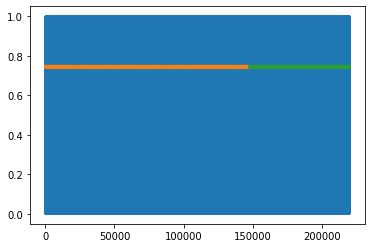

In [7]:
FILE_PATH_DRIVE = '/content/drive/My Drive/Colab Notebooks/'

numpy.random.seed(7)


# load the dataset
dataframe = pandas.read_csv(FILE_PATH_DRIVE + 'data/credit.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')


# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(2, input_shape=(1, look_back), return_sequences = True))
model.add(LSTM(2, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()